# Carrier Phase Synchronization and Subcarrier-Level Calibration in FR3 Wireless Links with Pi Radio

This project presents an experimental study of carrier phase synchronization and subcarrier-level calibration in FR3 wireless links using the Pi Radio platform. A QPSK-modulated signal is transmitted periodically at a fundamental carrier frequency of 10 GHz from two TX antennas, each carrying 1024 time-domain samples. On the receiver side, signals are captured from two RX antennas over 256 frames, with each frame also containing 1024 samples. The signal spans 1024 subcarriers, of which 520 are actively used and symmetrically centered around the DC subcarrier. For analysis purposes, we selected RX "antenna 0" and a single frame to focus on subcarrier-level behavior. Frequency-domain characteristics are examined using FFT and FFT-shift operations. Receiver calibration is performed using a reference dataset to compensate for hardware-induced amplitude and phase distortions. Subcarriers from −260 to +259 are extracted to isolate the active bandwidth. The system’s synchronization performance is evaluated through magnitude spectrum inspection and phase alignment. This setup enables characterization of phase mismatches and lays the groundwork for further CFO estimation and compensation studies.

##### Experimental Setup:
The experimental testbed consists of two Pi Radio devices and two Xilinx RFSoC platforms configured for over-the-air wireless transmission and reception. Each Pi Radio operates in the FR3 frequency band and is connected to a host computer that manages synchronization, data streaming, and signal processing tasks. The RFSoCs are responsible for digital upconversion and downconversion, DAC/ADC interfacing, and timing control. The host computer orchestrates the system through Python scripts, and the full data acquisition pipeline is based on the open-source code available at: https://github.com/ali-rasteh/RFSoC_SDR. This setup enables high-speed QPSK signal generation and reception at a 10 GHz carrier frequency with dual-antenna configurations on both the transmitter and receiver sides. Data is collected in the form of multi-frame captures for offline calibration and synchronization analysis.

### Loading Data
To begin the analysis, a dedicated load_data() function is used to import both the received signal and calibration reference from .npz files. The function allows flexible selection of the RX frame and antenna index—by default, "frame 0" and "antenna 0" are loaded for initial analysis. The calibration dataset is used to extract corresponding reference signals, which are later employed to correct for amplitude distortion in the FFT domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 

def load_data(data_path, calibration_data_path, rx_frame=0, antenna=0):
    """
    Load data from a .npz file.

    Parameters:
        data_path : str
            Path to the .npz file containing the data.
        calibration_data_path : str
            Path to the .npz file containing the calibration data.
        rx_frame : int
            The RX frame number to load.
        antenna : int
            The antenna number to load.
    
    Returns:
        rx_frame : numpy.ndarray
            The RX frame data for the specified antenna.
        tx_signal : numpy.ndarray
            The TX signal data for the specified antenna.
        calibration_signal : numpy.ndarray
            The calibration signal data for the specified antenna.
    """
    # Load the data
    data = np.load(data_path)
    calibration_data = np.load(calibration_data_path)
    # Extract the data
    txtd = data['txtd']
    rxtd_10 = data['rxtd_10.0']
    antenna_calibration_10 = calibration_data['rxtd_10.0']

    print(f"TX shape: {txtd.shape}, RX shape: {rxtd_10.shape}, Calib RX shape: {antenna_calibration_10.shape}")

    # Squeeze the data to remove single-dimensional entries
    txtd = np.squeeze(txtd)  # TX data

    # Choose RX frame and antenna
    rx_frame = rxtd_10[rx_frame, antenna]  # shape (1024,)
    tx_signal = txtd[antenna]      # shape (1024,)
    calibration_signal = antenna_calibration_10[:,antenna]  # shape (32, 1024)
    
    return rx_frame, tx_signal, calibration_signal


### Plotting Functions

In [2]:
def plot_fft_magnitude_spectra(tx_fft, rx_fft, used_range=259, n_fft=1024, figsize=(14, 6), fig_title="FFT Magnitude Spectra"):
    """
    Plots the FFT magnitude spectra for TX and RX, highlighting used subcarriers.

    Parameters:
        tx_fft (np.ndarray): FFT of transmitted signal
        rx_fft (np.ndarray): FFT of received signal (calibrated or not)
        used_range (int): Half-width of used subcarriers (default: 259 for [-259, +259])
        n_fft (int): FFT size (default: 1024)
        figsize (tuple): Size of the figure (default: (14, 6))
        fig_title (str): Title of the figure (default: "FFT Magnitude Spectra")
    """
    subcarrier_index = np.arange(-n_fft//2, n_fft//2)

    plt.figure(figsize=figsize)
    plt.suptitle(fig_title, fontsize=16)

    # TX FFT
    plt.subplot(1, 2, 1)
    plt.plot(subcarrier_index, 20*np.log10(np.abs(tx_fft) + 1e-12), label="TX FFT")
    plt.title("TX FFT Magnitude Spectrum")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Magnitude (dB)")
    plt.axvspan(-used_range, used_range, color='orange', alpha=0.2, label="Used Subcarriers")
    plt.grid(True)
    plt.legend()

    # RX FFT
    plt.subplot(1, 2, 2)
    plt.plot(subcarrier_index, 20*np.log10(np.abs(rx_fft) + 1e-12), label="RX FFT")
    plt.title("RX FFT Magnitude Spectrum")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Magnitude (dB)")
    plt.axvspan(-used_range, used_range, color='orange', alpha=0.2, label="Used Subcarriers")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_constellations(tx_syms, rx_syms, symbol_index=None, zero_idx=None, norm=False, figsize=(12, 6), axis_lim=None,
                        title1="TX Constellation", title2="RX Constellation", fig_title="Constellation Plot"):
    """
    Plots TX and RX constellations side by side.

    Parameters:
        tx_syms (np.ndarray): Transmitted symbols (complex)
        rx_syms (np.ndarray): Received symbols (complex)
        symbol_index (np.ndarray): Index array to filter symbols (optional)
        zero_idx (np.ndarray or list): Indices to exclude (optional)
        norm (bool): Normalize the TX symbols to the same scale (default: False)
        figsize (tuple): Figure size (default: (12, 6))
        fig_title (str): Title of the figure (default: "Constellation Plot")
        axis_lim (float): Axis limits for both plots (default: None)
        title1 (str): Title for the TX constellation plot (default: "TX Constellation")
        title2 (str): Title for the RX constellation plot (default: "RX Constellation")
    """

    # Handle optional filtering
    if symbol_index is not None and zero_idx is not None:
        mask = symbol_index != zero_idx
        tx_syms = tx_syms[mask]
        rx_syms = rx_syms[mask]
    
    # Handle optional tx normalization
    if norm:
        tx_syms = tx_syms / np.max(np.abs(tx_syms))

    fig = plt.figure(figsize=figsize)
    plt.suptitle(fig_title, fontsize=16)

    # TX Constellation
    plt.subplot(1, 2, 1)
    plt.scatter(np.real(tx_syms), np.imag(tx_syms), s=10, label="TX")
    plt.title(title1)
    plt.xlabel("In-Phase")
    plt.ylabel("Quadrature")
    plt.axis("equal")
    plt.grid(True)
    ax = fig.gca()
    if axis_lim:
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)

    # RX Constellation
    plt.subplot(1, 2, 2)
    plt.scatter(np.real(rx_syms), np.imag(rx_syms), s=10, label="RX")
    plt.title(title2)
    plt.xlabel("In-Phase")
    plt.ylabel("Quadrature")
    plt.axis("equal")
    plt.grid(True)
    ax = fig.gca()
    if axis_lim:
        ax.set_xlim(-axis_lim, axis_lim)
        ax.set_ylim(-axis_lim, axis_lim)

    plt.tight_layout()
    plt.show()


def plot_time_domain_signals(txtd, rxtd, norm=True, sample_rate=None, fig_title="Time-Domain Signal", figsize=(14, 6)):
    """
    Plots TX and/or RX time-domain waveforms.

    Parameters:
        txtd (np.ndarray): Time-domain signal to plot
        rxtd (np.ndarray): Second time-domain signal to plot
        sample_rate (float): Sampling rate (Hz) for optional time axis (optional)
        fig_title (str): Title for the figure (optional)
        figsize (tuple): Size of the figure (default: (14, 4))
        norm (bool): Normalize the signals to the same scale (default: True)
    """

    if sample_rate is not None:
        time_axis = np.arange(len(txtd)) / sample_rate
        x_label = "Time (s)"
    else:
        time_axis = np.arange(len(txtd))
        x_label = "Sample Index"

    plt.figure(figsize=figsize)
    plt.suptitle(fig_title, fontsize=16)

    if norm:
        txtd = txtd / np.max(np.abs(txtd))
        rxtd = rxtd / np.max(np.abs(rxtd))

    # Real part (I)
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, np.real(txtd), label='TX', color='blue')
    plt.plot(time_axis, np.real(rxtd), label='RX', color='orange', linestyle='--')
    plt.title(f"In-phase (Real)")
    plt.xlabel(x_label)
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    # Imag part (Q)
    plt.subplot(2, 1, 2)
    plt.plot(time_axis, np.imag(txtd), label='TX', color='blue')
    plt.plot(time_axis, np.imag(rxtd), label='RX', color='orange', linestyle='--')
    plt.title(f"Quadrature (Imag)")
    plt.xlabel(x_label)
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Antenna Calibration, FFT Processing and Time-Domain Reconstruction

This section processes received and transmitted signals in the **frequency domain** (FFT) and reconstructs their **time-domain representation** for alignment and visualization.

##### 1. Antenna Calibration

Each RF antenna has a different frequency response (gain), which introduces **amplitude distortion** across subcarriers in OFDM. Calibration compensates for that and gives us a flatter response.

Given:

* $R(f)$: received signal in FFT domain (complex)
* $|H_{\text{cal}}(f)|$: magnitude response (amplitude distortion only)

Accordingly, the corrected frequency response can be calculated as follows

$$
R_{\text{corrected}}(f) = \frac{R(f)}{|H_{\text{cal}}(f)|}
$$

This removes **amplitude distortion** caused by frequency-selective gain of the RF front-end.


##### 2. `process_rx_tx_fft()`: FFT and Subcarrier Extraction

This function performs the following:

- Computes the **FFT** of both the received frame and transmitted signal:
  
  $$
  R[k] = \text{FFT}(r[n]), \quad S[k] = \text{FFT}(s[n])
  $$

- Applies **antenna calibration**, if a known calibration signal is available. The received FFT is normalized to remove per-subcarrier gain variation:
  
  $$
  \hat{R}[k] = \frac{R[k]}{\mathbb{E}[|C[k]|]}
  $$

- Extracts the **active subcarriers** (e.g., indices from \(-259\) to \(+259\) for a 520-subcarrier system) by masking the DC term of the FFT spectrum.

This step is essential in our system because only a subset of subcarriers carries data.



##### 3. `compute_time_domain_signals()`: IFFT and Signal Reconstruction

This function converts frequency-domain data back into time-domain using the **inverse FFT** (IFFT). It supports both:

- Full-spectrum IFFT (no padding)
- **Zero-padded partial spectrum**, when only used subcarriers are available:

  $$
  r[n] = \text{IFFT}(R[k]), \quad \text{where } R[k] \text{ contains zero-padded inactive subcarriers}
  $$

The function handles:
- **fftshifted** inputs (common for DC centering)
- **re-centering** of spectrum using `ifftshift()`

This process enables:
- **Time-domain correlation**
- **Impulse response visualization**
- **Signal alignment via IFFT-domain metrics**


Together, these functions form the core of our **signal analysis**, enabling transformation between frequency and time domains while preserving structure and synchronization properties.


In [3]:
def process_rx_tx_fft(rx_frame, tx_signal, calibration_signal=None, n_fft=1024, subcarrier_range=259):
    """
    Processes RX and TX frames for OFDM FFT, calibration, and subcarrier extraction.

    Parameters:
        rx_frame (np.ndarray): Received time-domain frame
        tx_signal (np.ndarray): Transmitted time-domain signal
        calib_rx_frame (np.ndarray): Calibration RX frame
        n_fft (int): FFT size (default: 1024)
        subcarrier_range (int): Half-width of used subcarriers (default: 259 for [-259:+259])

    Returns:
        rx_syms (np.ndarray): Calibrated RX symbols (used subcarriers)
        tx_syms (np.ndarray): TX symbols (used subcarriers)
    """

    # FFT and shift
    rx_fft = np.fft.fftshift(np.fft.fft(rx_frame, n=n_fft))
    tx_fft = np.fft.fftshift(np.fft.fft(tx_signal, n=n_fft))

    # Antenna calibration
    if calibration_signal is not None:
        calibration_rx_fft = np.fft.fftshift(np.fft.fft(calibration_signal, n=n_fft))
        rx_fft /= np.mean(np.abs(calibration_rx_fft), axis=0)
        
    # Extract active subcarriers
    start = n_fft // 2 - subcarrier_range - 1
    end = n_fft // 2 + subcarrier_range
    used_idx = np.zeros(n_fft, dtype=bool)
    used_idx[start:end] = True

    rx_syms = rx_fft[used_idx]
    tx_syms = tx_fft[used_idx]

    return tx_syms, rx_syms, tx_fft, rx_fft


def compute_time_domain_signals(tx_fft, rx_fft, n_fft=1024, is_centered=True, used_range=None):
    """
    Converts RX and TX FFT-domain signals to time-domain using IFFT.

    Parameters:
        rx_fft (np.ndarray): RX frequency-domain data (can be full or partial).
        tx_fft (np.ndarray): TX frequency-domain data (can be full or partial).
        n_fft (int): Total FFT size (default: 1024).
        is_centered (bool): Whether the FFTs are fftshifted (default: True).
        used_range (int): Half-width of used subcarriers (e.g., 259 for -259:+259). If set,
                          the input is assumed to be partial and will be zero-padded.

    Returns:
        rx_time (np.ndarray): RX time-domain signal.
        tx_time (np.ndarray): TX time-domain signal.
    """

    def fft_to_time(fft_data):
        if used_range is not None:
            # Partial FFT: pad zeros to create full spectrum
            full_spec = np.zeros(n_fft, dtype=complex)
            start = n_fft // 2 - used_range - 1
            end = n_fft // 2 + used_range
            full_spec[start:end] = fft_data[start:end]
        else:
            full_spec = fft_data

        if is_centered:
            full_spec = np.fft.ifftshift(full_spec)

        return np.fft.ifft(full_spec, n=n_fft)

    rxtd = fft_to_time(rx_fft)
    txtd = fft_to_time(tx_fft)

    return txtd, rxtd


## Signal Analysis

In this section, we analyze the transmitted and received signals before and after calibration to evaluate system impairments and the effectiveness of correction. The code first loads a selected RX frame and antenna from both the raw measurement and the calibration dataset. FFTs are computed for the transmitted signal and the received signal—both uncalibrated and calibrated—using `process_rx_tx_fft()`. Time-domain representations are then reconstructed using inverse FFT, considering both the full bandwidth and the 520 used subcarriers (−259 to +259).

To visualize the results, the script generates FFT magnitude spectra, time-domain waveforms, and constellation diagrams. This dual-domain comparison reveals how receiver calibration significantly improves the signal alignment, phase accuracy, and subcarrier-level integrity, particularly evident in the calibrated constellation plots and spectral uniformity.

You can find the calibration data in the following drive link: https://drive.google.com/file/d/1lVLk2Rm0zhQKiAE-X8GvxJvGZfsHb-W6/view?usp=drive_link


## Experiment 1

TX shape: (1, 2, 1024), RX shape: (256, 2, 1024), Calib RX shape: (32, 2, 1024)


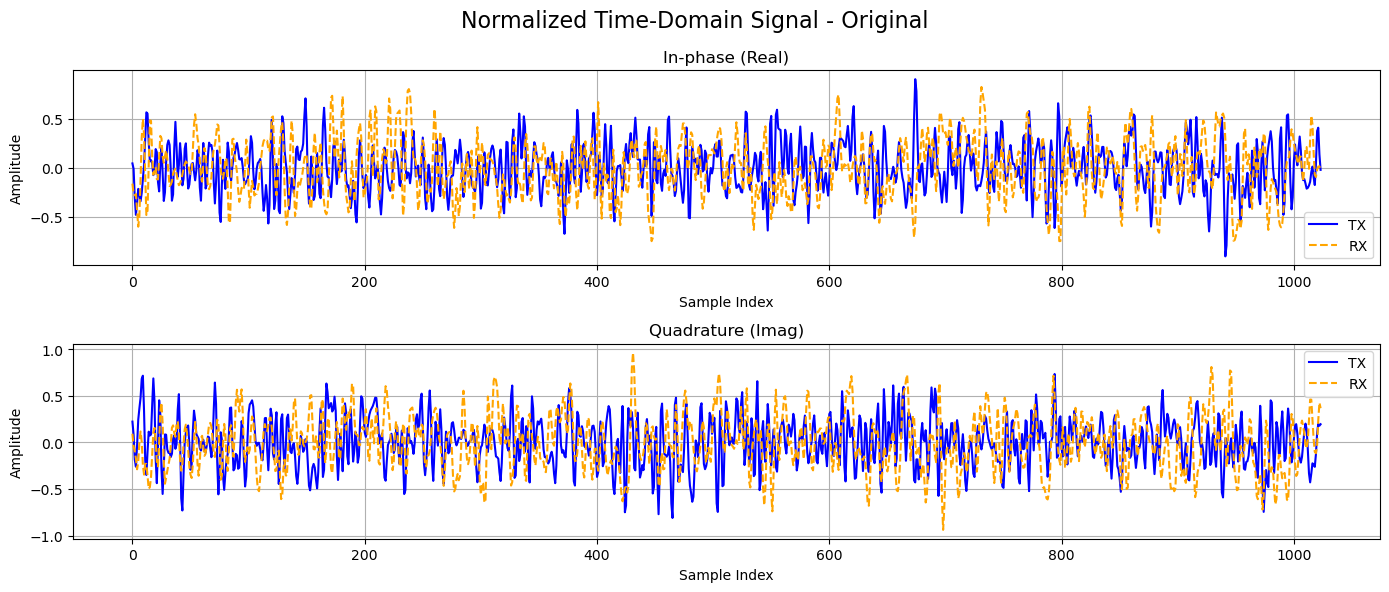

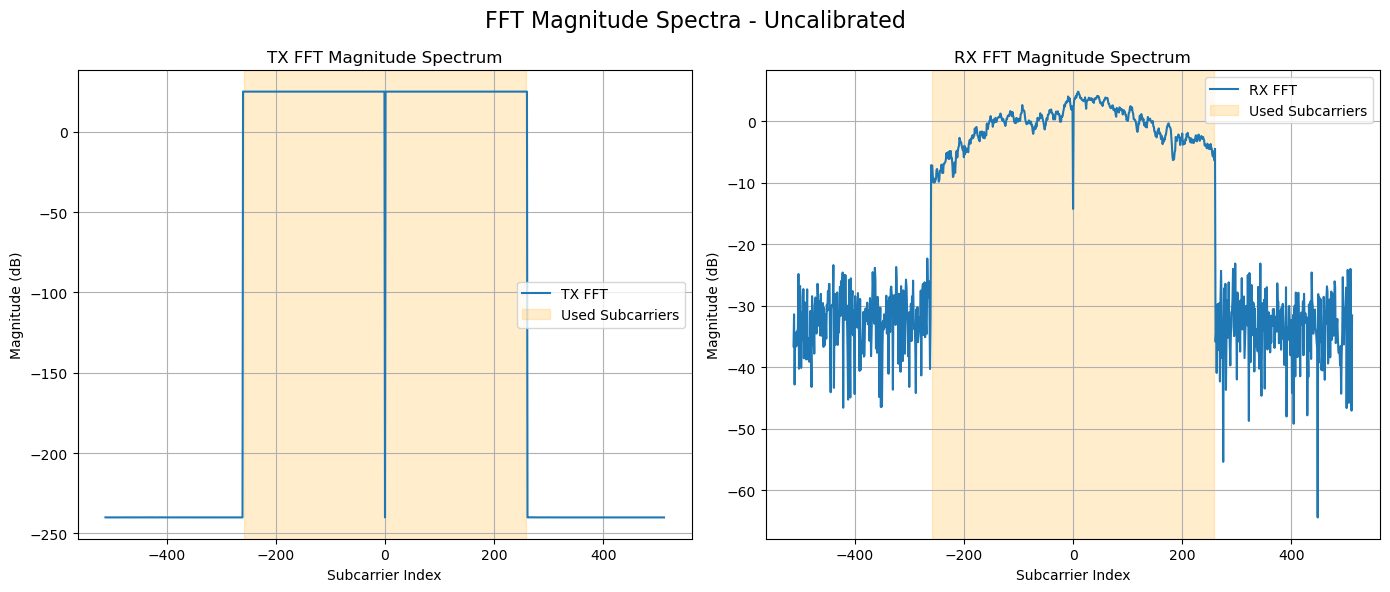

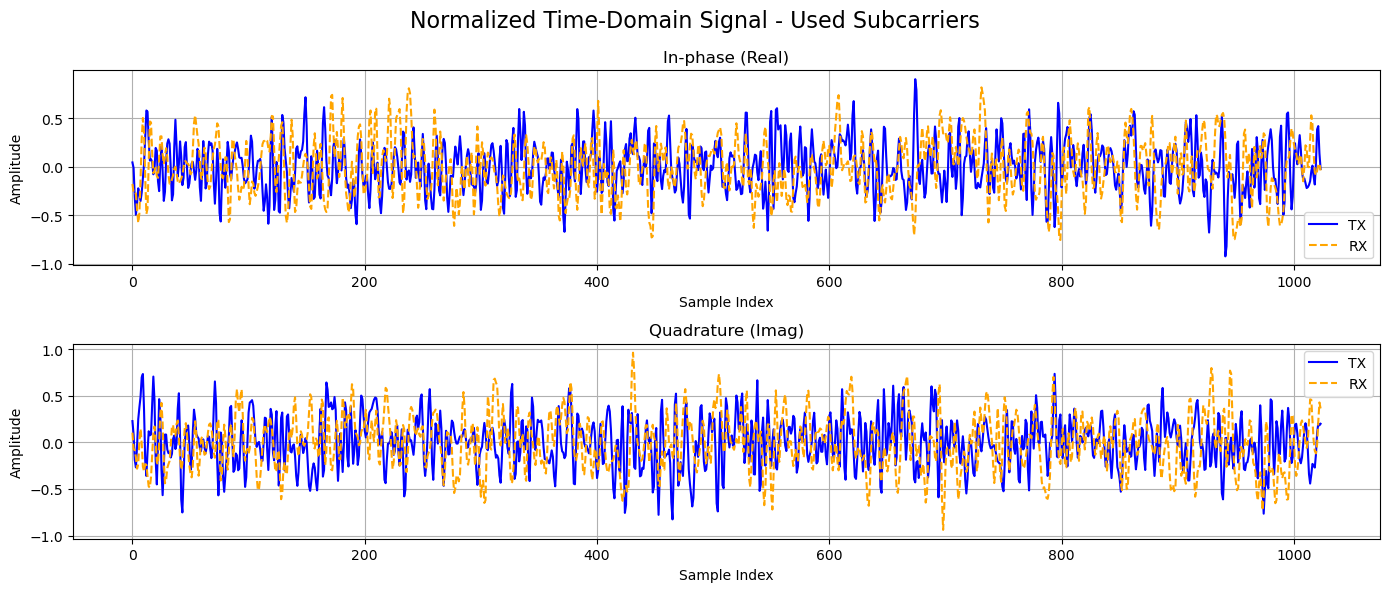

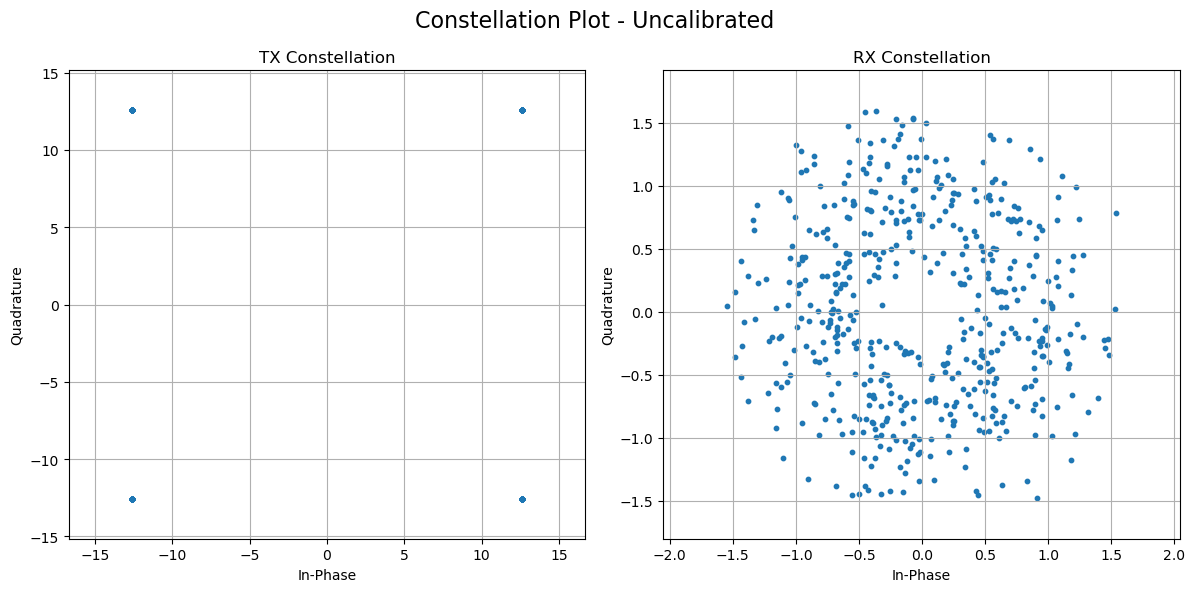

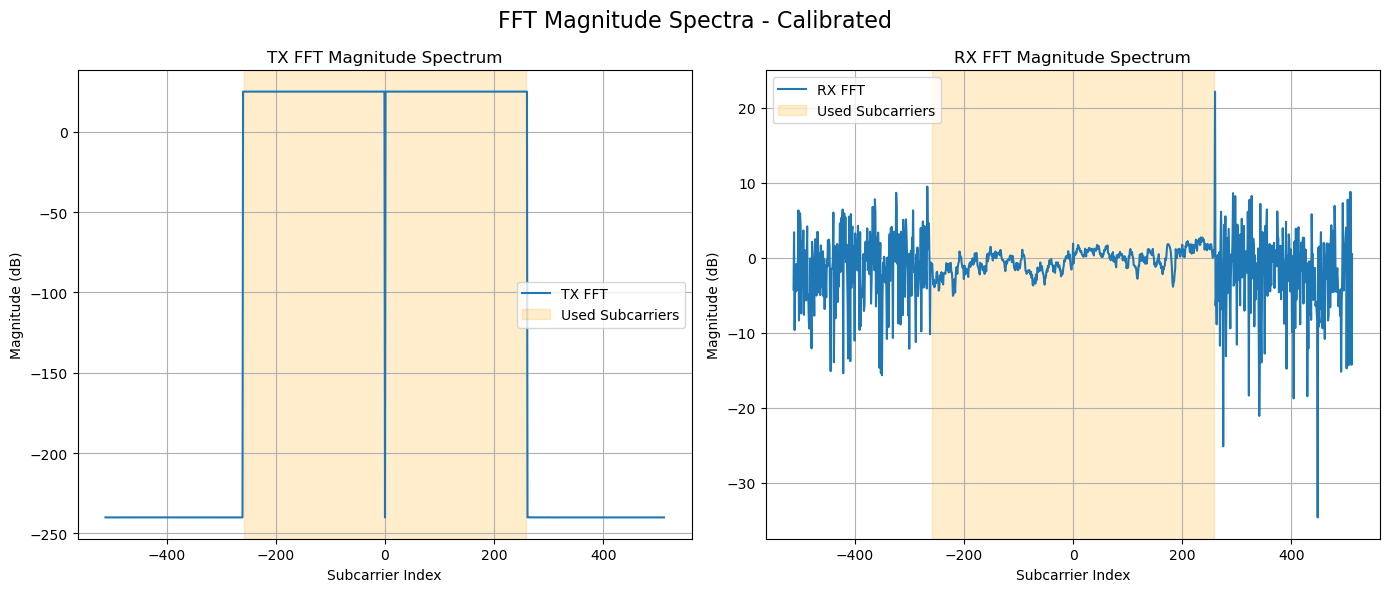

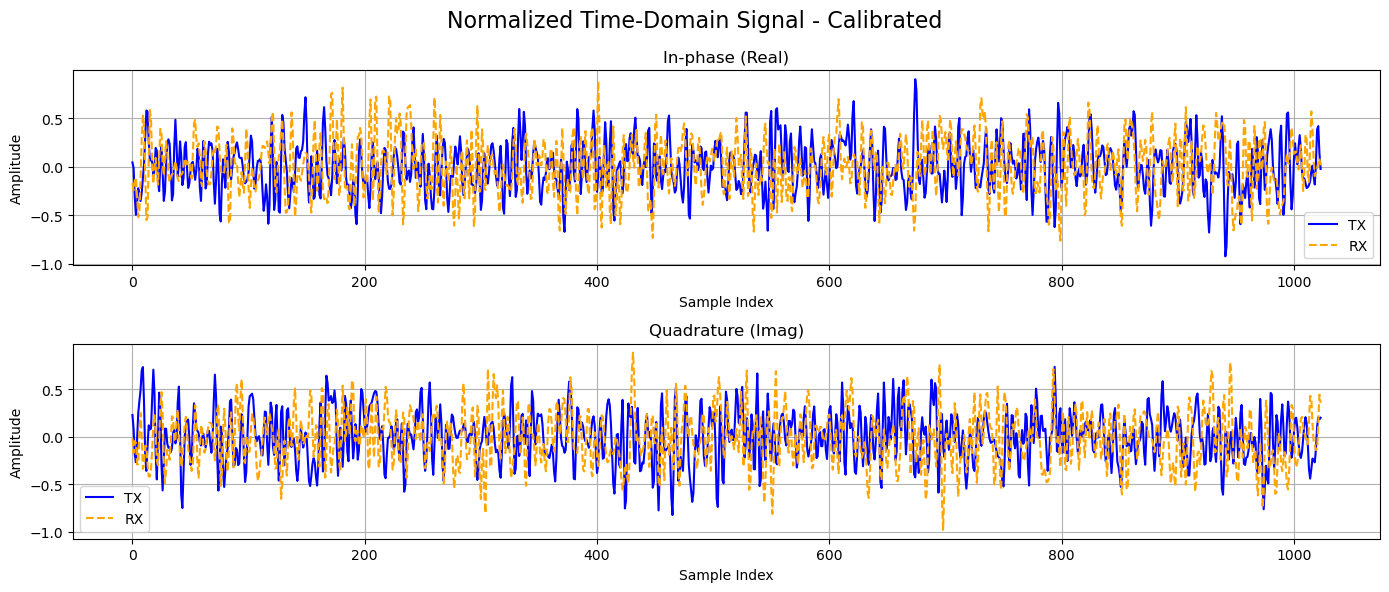

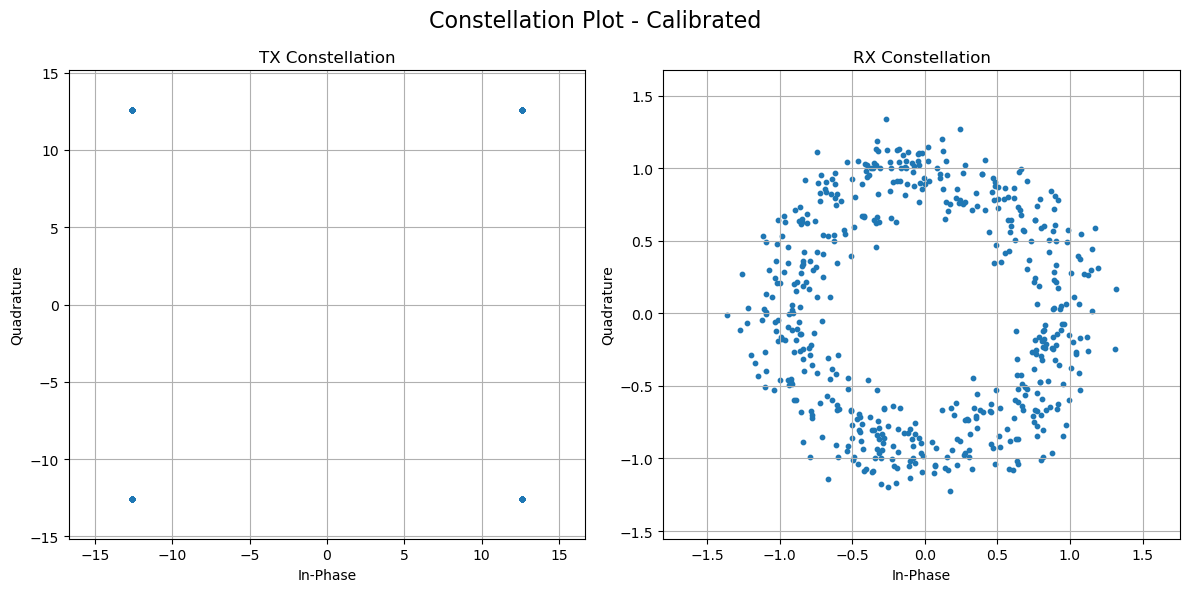

In [4]:
# Load data and choose RX frame and antenna
data_path = '10.0GHz_0ppm.npz'
calibration_data_path = '0_tx1_rx1_rx_rotate.npz'
rx_frame, tx_signal, calibration_signal = load_data(data_path, calibration_data_path, rx_frame=0, antenna=0)

# Compute FFTs and extract symbols
# Uncalibrated RX frame
tx_syms, rx_syms_orig, tx_fft, rx_fft_orig = process_rx_tx_fft(rx_frame, tx_signal)
# Calibrated RX frame
tx_syms, rx_syms, tx_fft, rx_fft = process_rx_tx_fft(rx_frame, tx_signal, calibration_signal)

# Compute time-domain signals from FFTs
txtd_orig, rxtd_orig = compute_time_domain_signals(tx_fft, rx_fft_orig)
txtd_used, rxtd_orig_used = compute_time_domain_signals(tx_fft, rx_fft_orig, used_range=259)
txtd_used, rxtd_calib_used = compute_time_domain_signals(tx_fft, rx_fft, used_range=259)

# Subcarrier index axis
subcarrier_index = np.arange(-512, 512)
symbol_index = np.arange(0, len(tx_syms))
zero_idx = len(tx_syms) // 2 + 1 # 0 Hz index for TX and RX symbols

# Plotting
# All the subcarriers
plot_time_domain_signals(txtd_orig, rxtd_orig, fig_title="Normalized Time-Domain Signal - Original")

# Plot FFT magnitude spectra
plot_fft_magnitude_spectra(tx_fft, rx_fft_orig, fig_title="FFT Magnitude Spectra - Uncalibrated")
plot_time_domain_signals(txtd_used, rxtd_orig_used, fig_title="Normalized Time-Domain Signal - Used Subcarriers")
plot_constellations(tx_syms, rx_syms_orig, symbol_index=symbol_index, zero_idx=zero_idx, fig_title="Constellation Plot - Uncalibrated")

plot_fft_magnitude_spectra(tx_fft, rx_fft, fig_title="FFT Magnitude Spectra - Calibrated")
plot_time_domain_signals(txtd_used, rxtd_calib_used, fig_title="Normalized Time-Domain Signal - Calibrated")
plot_constellations(tx_syms, rx_syms, symbol_index=symbol_index, zero_idx=zero_idx, fig_title="Constellation Plot - Calibrated")


### Step 1: Time Synchronization via Circular Cross-Correlation

The `align_rx_with_tx()` function estimates and corrects the **time offset** (lag) between a received signal frame and a known transmitted signal using **circular cross-correlation**.

- Time misalignment between TX and RX causes symbol or frame shifts.
- To align them, we compute the **cross-correlation**:

  $$
  \text{corr}[n] = \sum_{k} r[k] \cdot s^*[k + n]
  $$

- In practice, `np.correlate(..., mode='full')` computes a **linear correlation**, but since OFDM and many SDR systems are cyclic, this is effectively a **circular alignment** technique.

- The **lag** (time offset) corresponding to the **maximum magnitude of the correlation** indicates where the RX frame matches best with the TX signal.

##### Alignment Step

- Once the best lag is found:

  $$
  \text{lag} = \arg\max_n |\text{corr}[n]|
  $$

- The RX frame is then **circularly shifted** to align with the TX signal:

  $$
  \text{rx\_aligned}[n] = \text{rx\_frame}[(n + \text{lag}) \bmod N]
  $$

This method is a **first step** in our synchronization pipeline as an initial phase correction.


In [5]:
def align_rx_with_tx(rx_frame, tx_signal, plot=True, label="RX", figsize=(14, 4)):
    """
    Aligns RX frame to TX signal using circular cross-correlation.

    Parameters:
        rx_frame (np.ndarray): Received time-domain frame (complex or real)
        tx_signal (np.ndarray): Transmitted time-domain signal (complex or real)
        plot (bool): Whether to plot the correlation magnitude
        label (str): Label for the plot title (default: "RX")
        figsize (tuple): Size of the figure

    Returns:
        rx_aligned (np.ndarray): Circularly shifted RX frame
        lag (int): Estimated time offset (lag)
        corr (np.ndarray): Cross-correlation result
    """
    # Compute full circular cross-correlation
    corr = np.correlate(rx_frame, tx_signal, mode='full')
    lag = np.argmax(np.abs(corr)) # Find the lag with maximum correlation

    # Circularly shift RX frame to align
    rx_aligned = np.roll(rx_frame, -lag)

    if plot:
        lags = np.arange(-len(tx_signal) + 1, len(tx_signal))
        plt.figure(figsize=figsize)
        plt.plot(lags, np.abs(corr), color='purple')
        plt.title(f'Cross-Correlation between {label} and TX - Estimated time offset: {lags[lag]}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation Magnitude')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return rx_aligned, lag, corr

First, we applied cross correlation based time domain synchronization followed by antenna calibration.

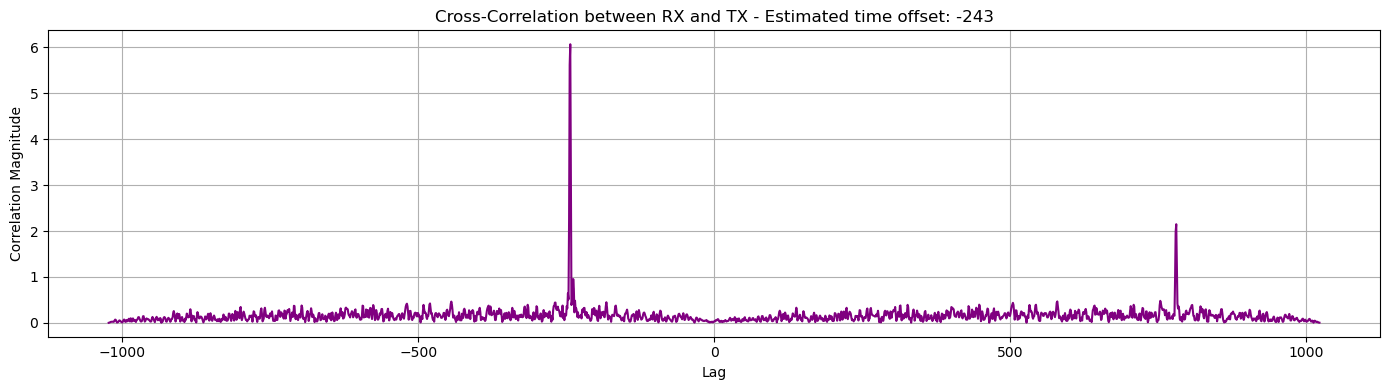

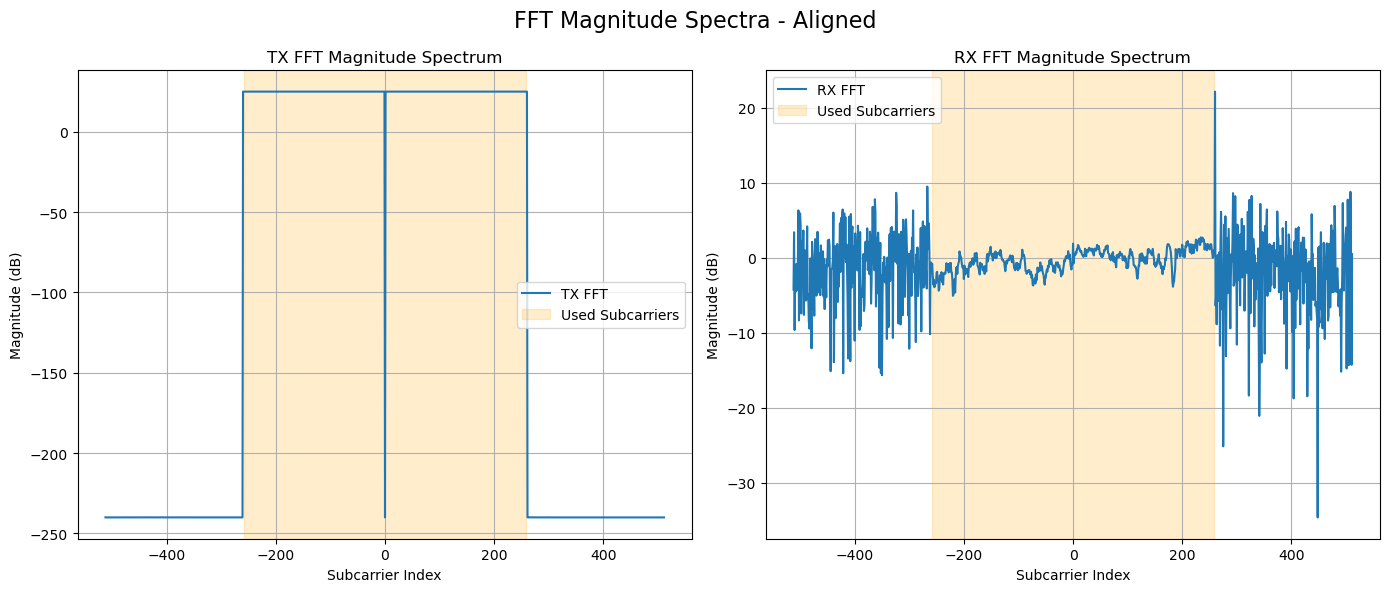

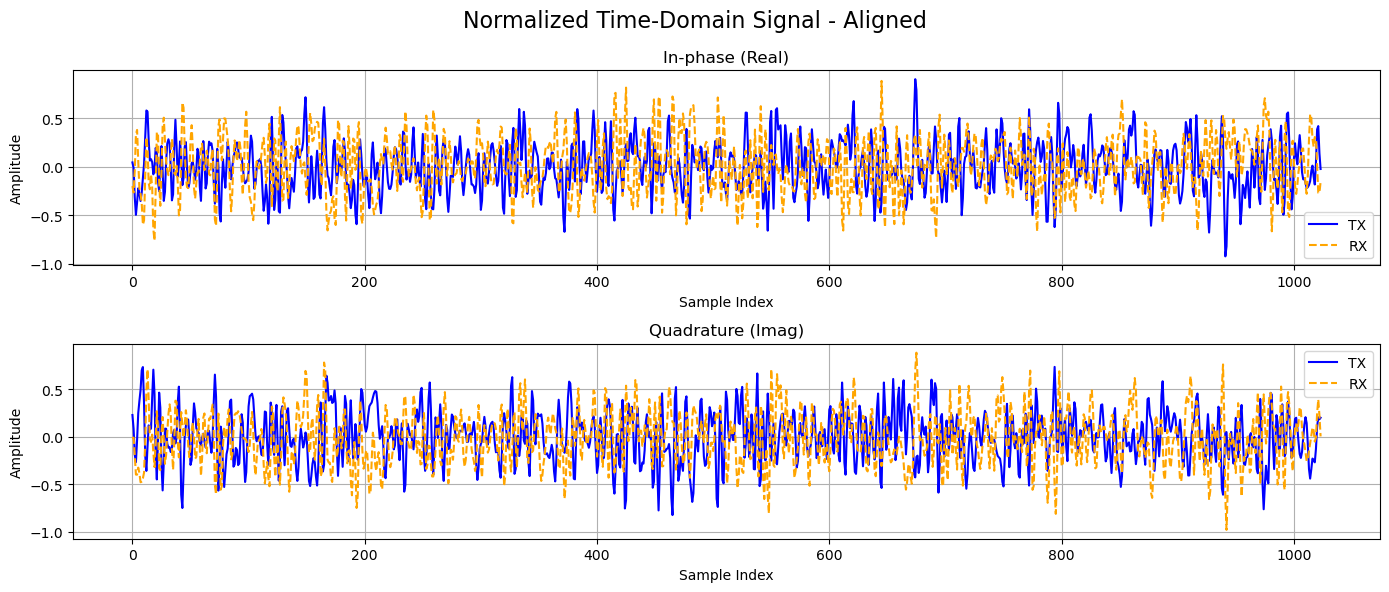

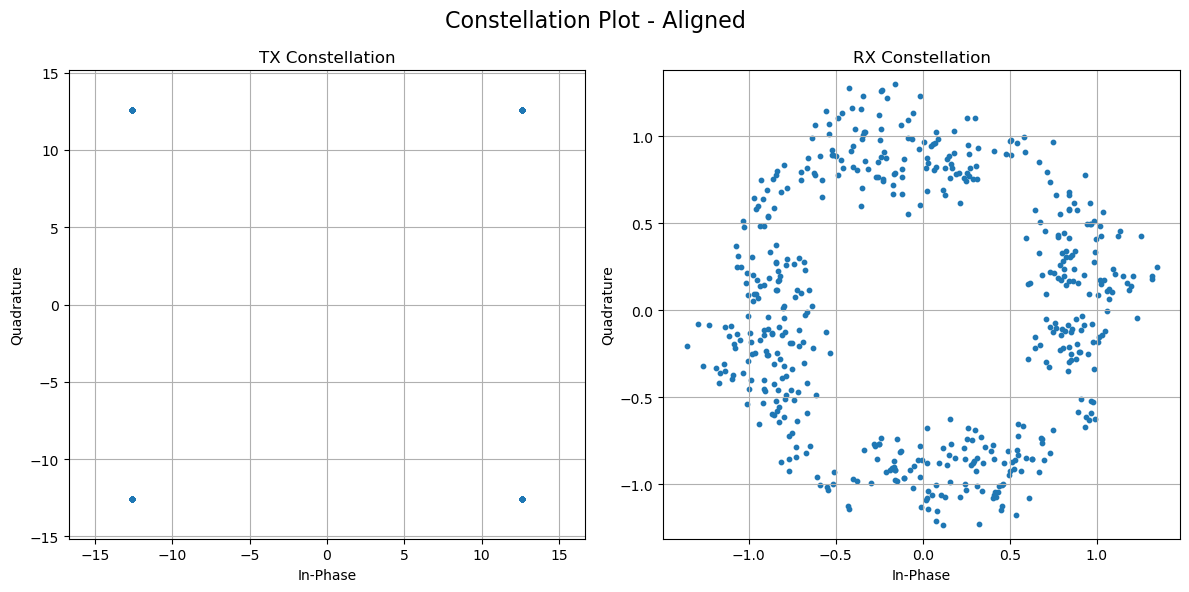

In [6]:
# Align RX with TX in time domain 
rx_frame_aligned, _, _ = align_rx_with_tx(rx_frame, tx_signal)

# Calibrated RX frame
tx_syms, rx_syms, tx_fft, rx_fft = process_rx_tx_fft(rx_frame_aligned, tx_signal, calibration_signal)

# Compute time-domain signals from FFTs
txtd_used, rxtd_aligned = compute_time_domain_signals(tx_fft, rx_fft, used_range=259)

# Subcarrier index axis
subcarrier_index = np.arange(-512, 512)
symbol_index = np.arange(0, len(tx_syms))
zero_idx = len(tx_syms) // 2 + 1 # 0 Hz index for TX and RX symbols

# Plotting
plot_fft_magnitude_spectra(tx_fft, rx_fft, fig_title="FFT Magnitude Spectra - Aligned")
plot_time_domain_signals(txtd_used, rxtd_aligned, fig_title="Normalized Time-Domain Signal - Aligned")
plot_constellations(tx_syms, rx_syms, symbol_index=symbol_index, zero_idx=zero_idx, fig_title="Constellation Plot - Aligned")



### Step 2: Pilot-Aided Phase Difference Estimation and Interpolation

This section estimates the phase offset between received and transmitted QPSK symbols, using known pilot locations to perform smoothing via interpolation:

##### 1. Symbol Normalization and Phase Error Calculation
- Transmitted symbols are first normalized to unit power:

  $$
  s_n^{\text{norm}} = \frac{s_n}{\sqrt{s_n s_n^*}}
  $$

- The per-symbol complex ratio is computed to extract the phase difference according to Least Square Estimation (LSE) method:

  $$
  e_n = \frac{r_n s_n^*}{s_n s_n^*}
  $$

- This yields a phase error for each symbol:

  $$
  \theta_{\text{err}}[n] = \angle\left( \frac{r_n}{s_n} \right)
  $$

- These phase errors are then **unwrapped** to produce a continuous phase drift estimate.

##### 2. Pilot-Based Sampling and Cubic Interpolation
- Pilot symbols are placed at regular intervals (e.g., every 7 symbols), so the unwrapped phase is **sampled** at pilot positions:

  $$
  n_{\text{pilot}} = [0, 7, 14, \dots]
  $$

- The sampled phase values are then interpolated using **cubic spline interpolation**:

  $$
  \theta_{\text{interp}}(n) = \text{interp1d}\left( n_{\text{pilot}}, \theta[n_{\text{pilot}}], \text{"cubic"} \right)
  $$

- This provides a smooth phase estimate across all symbols, which can be used for CFO correction or tracking.

This method provides a **robust, pilot-aided phase estimate** that is smoother and less sensitive to noise.


Second, we place pilot symbols distributed at every 7 symbols and we compute phase difference over them using LSE. Then, we interpolate the result across the entire signal duration in order to have a course estimation of the existing time varying phase error. 

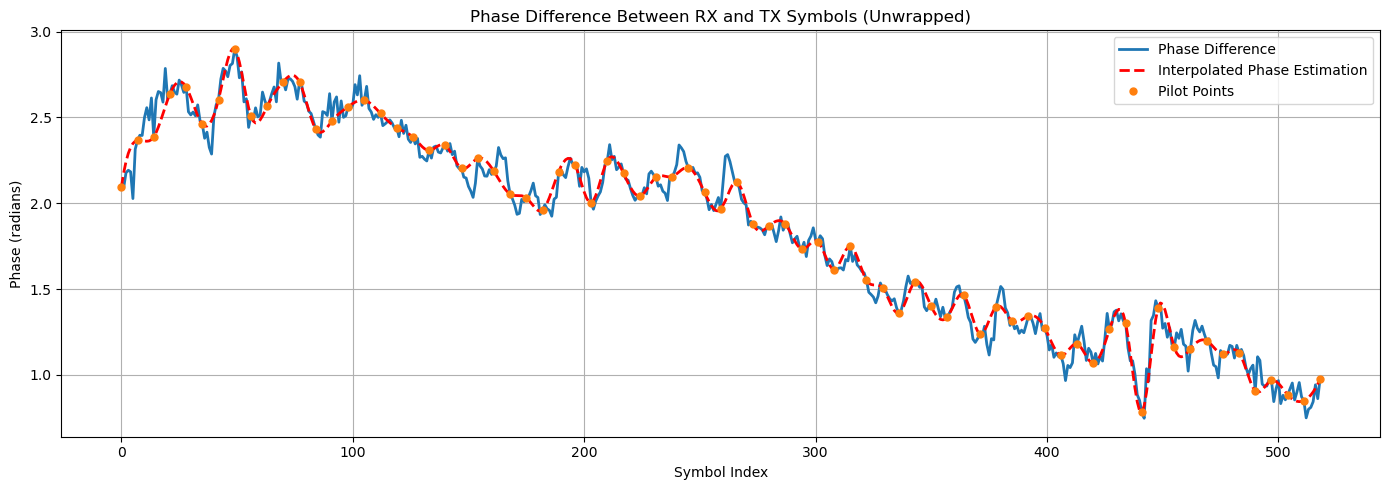

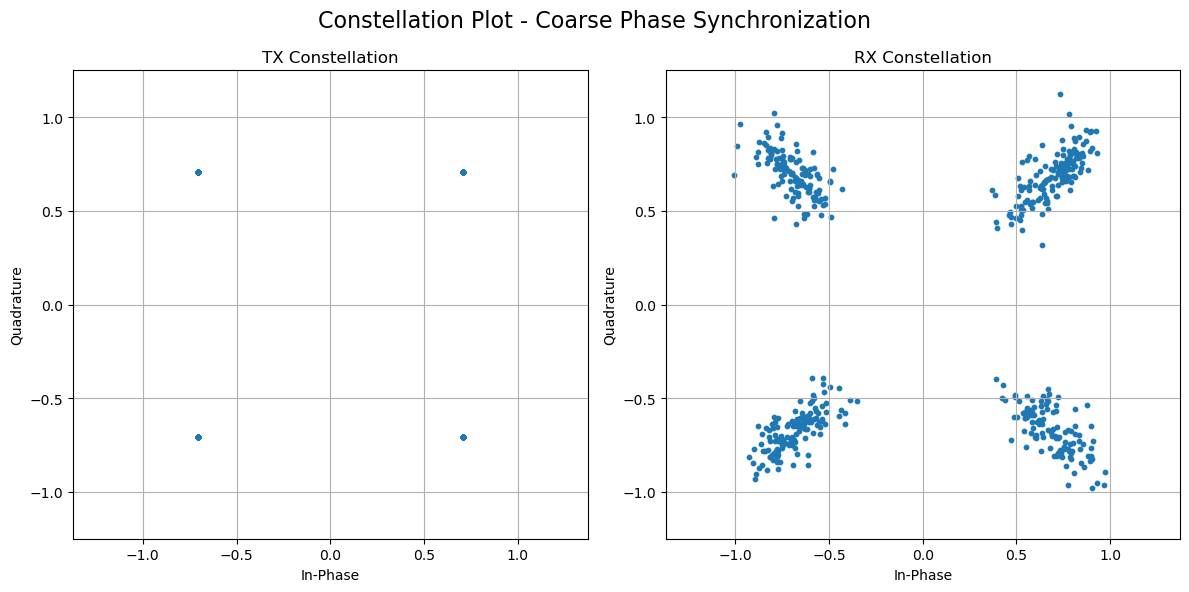

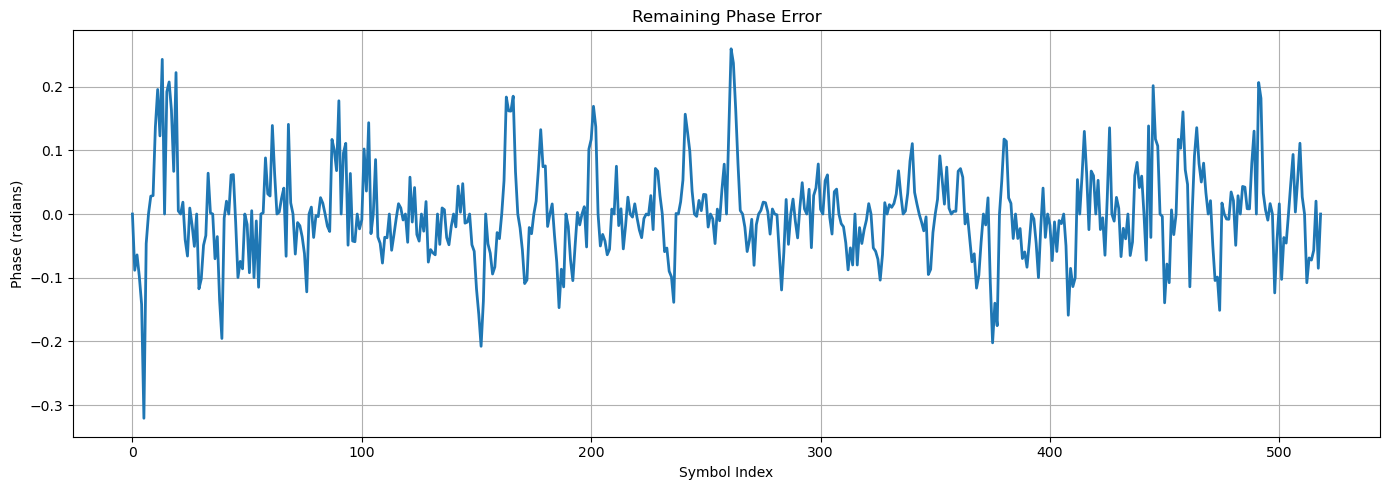

In [7]:
# phase difference
tx_syms = tx_syms / np.sqrt(tx_syms * np.conj(tx_syms)) # normalize TX symbols
sym_err = rx_syms * np.conj(tx_syms) / (tx_syms * np.conj(tx_syms)) # calculate error based on LSE
phase_diff = np.angle(sym_err) # phase difference
phase_unwrapped_1 = np.unwrap(phase_diff) # unwrap phase difference

n = np.arange(len(phase_unwrapped_1))
mask = n != zero_idx # mask 0 Hz for plotting
pilot_interval = 7 # pilots are distributed in every "pilot_interval"
n_pilot = n[::pilot_interval] # pilot indexes
phase_pilot = phase_unwrapped_1[::pilot_interval]

# interpolate the phase difference
f = interp1d(n_pilot, phase_pilot, kind='cubic')
phase_interp = f(n)

# Plot phase error estimation
plt.figure(figsize=(14, 5))
plt.plot(n[mask], phase_unwrapped_1[mask], label="Phase Difference", linewidth=2)
plt.plot(n[mask], phase_interp[mask], '--r', label=f"Interpolated Phase Estimation", linewidth=2)
plt.plot(n_pilot, phase_pilot, 'o', label="Pilot Points", markersize=5)
plt.xlabel("Symbol Index")
plt.ylabel("Phase (radians)")
plt.title("Phase Difference Between RX and TX Symbols (Unwrapped)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Phase Equalization
rx_syms_equalized = np.array([sym*np.exp(-1j * phase_interp[i]) for i, sym in enumerate(rx_syms)])

# Plot the equalized constellation
plot_constellations(tx_syms, rx_syms_equalized, symbol_index=symbol_index, zero_idx=zero_idx, axis_lim=1.5, fig_title="Constellation Plot - Coarse Phase Synchronization")

# Plot phase error
plt.figure(figsize=(14, 5))
plt.plot(n[mask], phase_unwrapped_1[mask]-phase_interp[mask], linewidth=2)
plt.xlabel("Symbol Index")
plt.ylabel("Phase (radians)")
plt.title("Remaining Phase Error")
plt.grid(True)
plt.tight_layout()
plt.show()


As seen. this step mitigates the excessive phase shift on the constellation diagram. However, there is still remaining phase error. Therefore, we need a fine synchronization step.

In the fine synchronization stage, we use a decision-directed PLL, which relies on accurate symbol decisions. Therefore, coarse synchronization becomes especially critical — without it, the PLL may fail to lock due to incorrect symbol decisions caused by large initial offsets.

### Step 3: Fine Synchronization with a Digital PI PLL

This section includes two key components of the synchronization pipeline:

##### 1. QPSK Hard Decision via Maximum Likelihood (ML)
- The `decision_qpsk()` function maps each received complex symbol to the **nearest QPSK constellation point** using a distance-based maximum likelihood decision rule.
- The QPSK constellation is defined at four angles: {π/4, 3π/4, 5π/4, 7π/4}.
- For each received symbol \( $r_n$ \), the decision is:

  $$
  \hat{s}_n = \arg\min_{s \in \mathcal{S}} |r_n - s|
  $$

- This process ensures optimal symbol detection under AWGN conditions and is used for both demodulation and phase error computation.

##### 2. Symbol-Space Phase-Locked Loop (PLL) with Pilot-Aided Resets
- The `pll_qpsk()` function implements a discrete-time **symbol-level PLL** with a **PI loop filter**.
- It operates in a decision-directed manner but resets the phase and integrator state at known **pilot symbol intervals** to prevent lock loss.
- The phase error is estimated as the imaginary part of the product:

  $$
  e[n] = \Im\left( y_{\text{init}} \cdot y_{\text{dec}}^* \right)
  $$

- Loop filter design follows control-theoretic tuning using damping factor \( $\zeta$ \) and normalized bandwidth \( $B_nT_s$ \):

  $$
  \begin{align*}
  a &= \zeta + \frac{1}{4\zeta} \\
  K_p &= \frac{1}{K_D K_0 L} \cdot \frac{4 \zeta B_n T_s}{a} \\
  K_i &= \frac{1}{K_D K_0 L^2} \cdot \frac{4 (B_n T_s)^2}{a^2}
  \end{align*}
  $$

- The PLL:
  - **Tracks residual carrier phase and slow CFO**
  - **Uses pilot-based resets** to improve robustness against error accumulation
  - **Prevents integrator wind-up** via clipping

This combination enables robust phase synchronization under noisy channel conditions.


In [8]:
def decision_qpsk(rx_symbols):
    """
    Distance-based decision for QPSK symbols.

    Parameters:
        symbol : complex or np.ndarray
            The received symbol(s) to decide on

    Returns:
        decision : complex or np.ndarray
            Nearest QPSK constellation point(s)
    """

    # Define ideal QPSK constellation points (at 45°, 135°, 225°, 315°)
    qpsk_constellation = np.exp(1j * (np.pi/4 + np.pi/2 * np.arange(4)))  # [π/4, 3π/4, 5π/4, 7π/4]

    rx_symbols = np.asarray(rx_symbols)  # Ensure array input

    # Compute the distances to each constellation point
    distances = np.abs(rx_symbols.reshape(1,-1) - qpsk_constellation.reshape(-1,1))
    idx = np.argmin(distances, axis=0) # minimum distance index
    decision = qpsk_constellation[idx] # ML decision

    return decision, idx


def pll_qpsk(received, phase_init, zeta = 0.707, BnTs = 0.05, pilot_interval=7, tx_syms=None):
    """
    QPSK symbol-space PLL with PI loop filter
    Parameters:
        received : np.ndarray
            Received QPSK symbols
        phase_init : np.ndarray
            Initial phase estimates (complex)
        zeta : float
            Damping factor (0 < zeta < 1)
        BnTs : float
            Phase noise bandwidth normalized to symbol period
        pilot_interval : int
            Interval between pilot symbols
        tx_syms : np.ndarray
            Transmitted symbols (to access pilot symbols)
    Returns:
        corrected : np.ndarray
            Phase-corrected symbols
        phase_track : np.ndarray
            Phase estimates
    """

    N = len(received)
    corrected = np.zeros(N, dtype=complex)
    phase_track = np.zeros(N)
    phase_est = phase_init[0]
    integral = 0.0

    # Define PLL parameters
    KD = 1.0          # Phase detector gain
    K0 = 1.0          # VCO/NCO gain
    L = 1
    a = zeta + 1 / (4 * zeta)                               # Intermediate term for reuse
    Kp = (1 / (KD * K0 * L)) * (4 * zeta / a) * BnTs        # Proportional gain
    Ki = (1 / (KD * K0 * L**2)) * (4 / a**2) * (BnTs ** 2)  # Integral gain

    for n in range(N):
        # Skip the dc term
        if n == len(tx_syms) // 2 + 1:
            continue
        # Reset the PLL at pilot symbols
        if n % pilot_interval == 0:
            # Reset the PLL at pilot symbols
            phase_est = phase_init[n]
            integral = 0.0
        # Apply current phase correction
        y_init = received[n] * np.exp(-1j * phase_est)

        # QPSK decision
        y_dec, _ = decision_qpsk(y_init)
        if tx_syms is not None and n % pilot_interval == 0:
            # Compute error based on pilot symbol
            y_dec = tx_syms[n]

        # Phase error
        error = KD * np.imag(y_init * np.conj(y_dec))
        # PI loop filter
        integral += error
        # Clip integral to prevent windup
        integral = np.clip(integral, -np.pi/2, np.pi/2)
        # Output of loop filter
        out_LF = Kp * error + Ki * integral
        # Phase estimation
        phase_est += K0 * out_LF

        # Apply refined phase correction and store the results
        corrected[n] = received[n] * np.exp(-1j * phase_est)
        phase_track[n] = phase_est

    return corrected, phase_track


Lastly, we apply our PLL as a fine synchronization method and plot the resulting constellation diagrams.

#### PLL Design Parameters: \( $\zeta$ \) and \( $B_nT_s$ \)

In a digital Phase-Locked Loop (PLL) — particularly one with a PI controller — the parameters \( $\zeta$ \) and \( $B_nT_s$ \) play a central role in determining the loop's performance and stability.

##### \( $\zeta$ \): Damping Factor

- Controls *how smoothly and quickly the PLL responds* to phase error.
- Influences whether the loop is underdamped, critically damped, or overdamped:
  
  - \(  $\zeta$ < 0.5 \): underdamped → fast but overshoots or oscillates  
  - \(  $\zeta$ = 0.707 \): critically damped → optimal trade-off  
  - \(  $\zeta$ > 1 \): overdamped → slow but stable

- *Higher damping* → smoother response  
- *Lower damping* → quicker reaction but may cause instability


##### \( $B_nT_s$ \): Normalized Loop Bandwidth

- Represents the *loop bandwidth* normalized to the symbol period:
  
  $$
  B_nT_s = B_n \cdot T_s
  $$

  where:
  - \($B_n$\): loop bandwidth in Hz  
  - \($T_s$\): symbol duration (in seconds)

- Determines the *tracking speed vs. noise sensitivity*:
  - Small \( $B_nT_s$ \): better noise rejection, slower adaptation
  - Large \( $B_nT_s$ \): faster tracking, more noise sensitivity

- Typical value as a reference starting point: $B_nT_s$ = 0.1

Intuitively,
- *\( $\zeta$ \): controls *how smooth the loop behaves  
- *\( $B_nT_s$ \): controls *how fast the loop reacts to changes

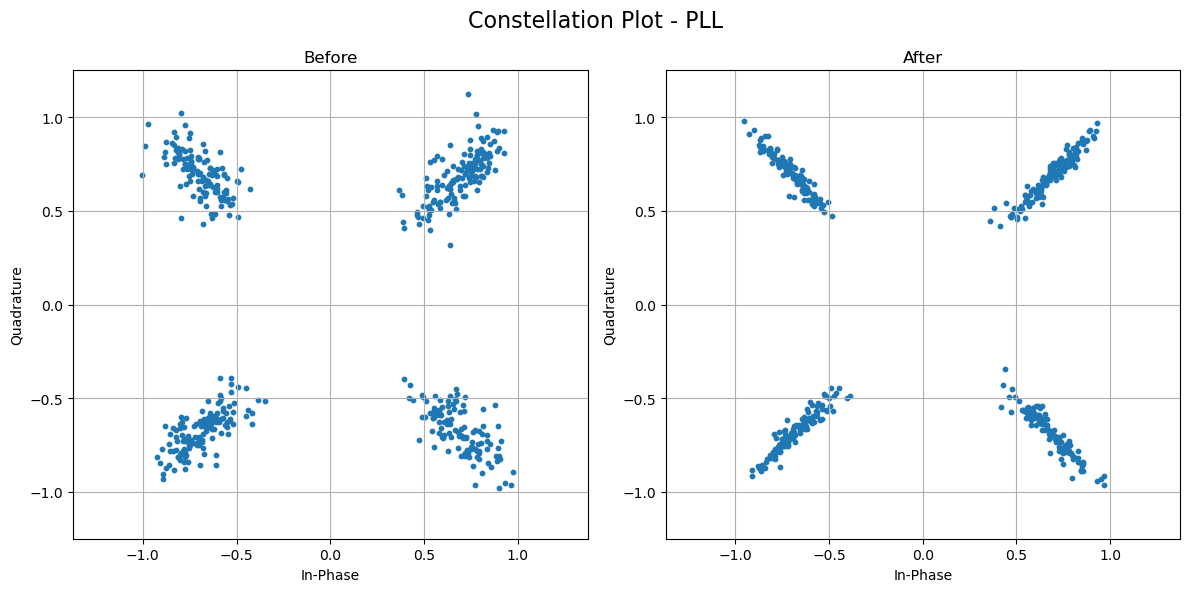

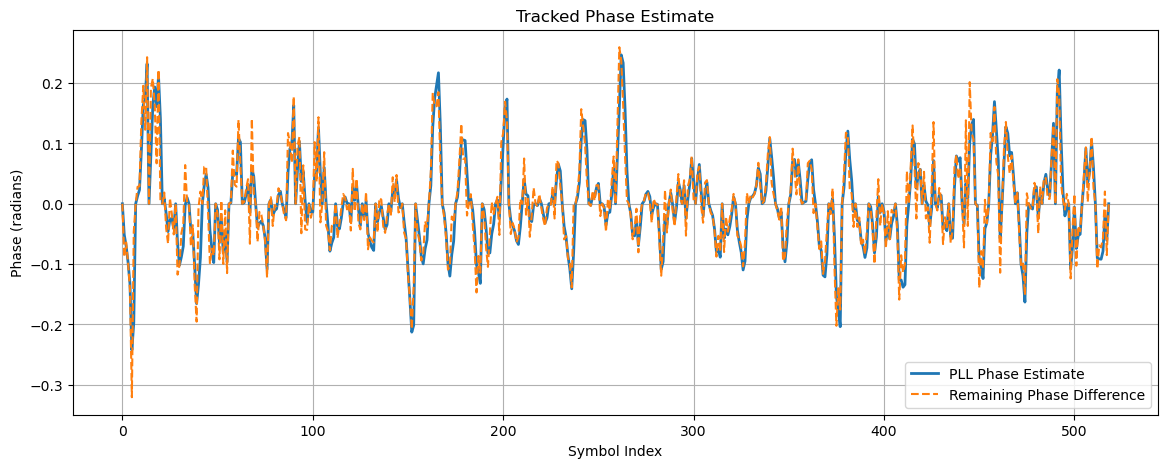

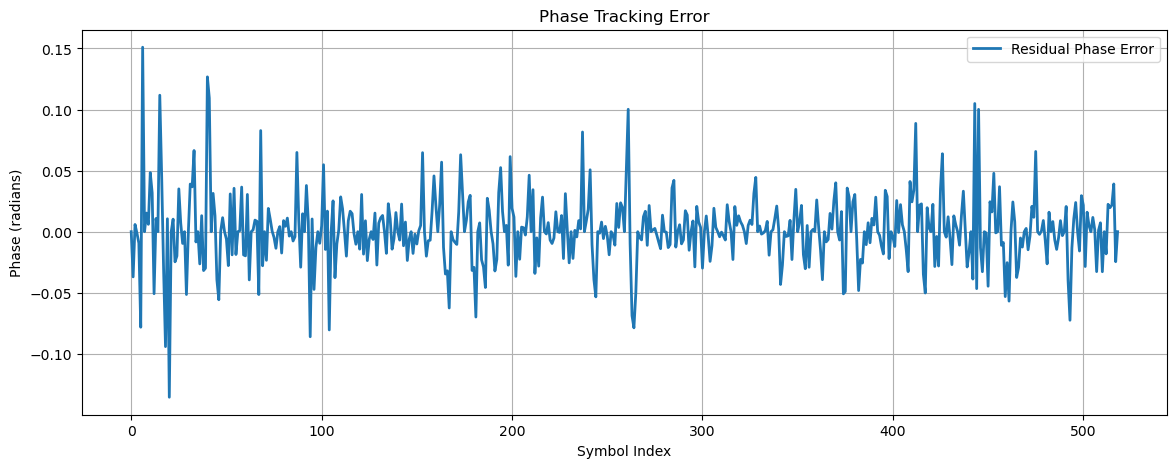

In [9]:
# Remaining phase error
sym_err = rx_syms_equalized * np.conj(tx_syms) / (tx_syms * np.conj(tx_syms)) # calculate error based on LSE
phase_diff = np.angle(sym_err) # phase difference
phase_unwrapped_2 = np.unwrap(phase_diff)

corrected, phase_track = pll_qpsk(rx_syms_equalized, phase_init=phase_unwrapped_2, zeta=0.707, BnTs=0.2,
                                  pilot_interval=pilot_interval, tx_syms=tx_syms)

# Plot constellation before and after PLL
plot_constellations(rx_syms_equalized, corrected, symbol_index=symbol_index, zero_idx=zero_idx, axis_lim=1.5,
                    title1="Before", title2="After", fig_title="Constellation Plot - PLL")

# Plot phase tracking
plt.figure(figsize=(14, 5))
plt.plot(n[mask], phase_track[mask], label="PLL Phase Estimate", linewidth=2.0)
plt.plot(n[mask], phase_unwrapped_1[mask]-phase_interp[mask], linestyle='--', label="Remaining Phase Difference", linewidth=1.5)
plt.title("Tracked Phase Estimate")
plt.xlabel("Symbol Index")
plt.ylabel("Phase (radians)")
plt.legend()
plt.grid(True)
plt.show()

# Plot residual phase error
plt.figure(figsize=(14, 5))
plt.plot(n[mask], phase_unwrapped_2[mask]-phase_track[mask], label="Residual Phase Error", linewidth=2.0)
plt.title("Phase Tracking Error")
plt.xlabel("Symbol Index")
plt.ylabel("Phase (radians)")
plt.legend()
plt.grid(True)
plt.show()

### Step 4: EVM and SER Metrics for QPSK

This section computes key performance metrics for a QPSK system:

##### 1. Error Vector Magnitude (EVM)
- EVM measures how far received symbols deviate from their ideal constellation points.
- It is calculated as the root mean square (RMS) of the normalized Euclidean error:
  
$$\text{EVM}_{\text{rms}} = \sqrt{ \frac{1}{N} \sum_{n=1}^{N} \frac{|r_n - s_n|^2}{|s_n|^2} }$$

- Also expressed in dB as:
  
$$\text{EVM}_{\text{dB}} = 10 \log_{10}(\text{EVM}_{\text{rms}}^2)$$

- Lower EVM indicates better modulation quality and less distortion.

##### 2. Symbol Error Rate (SER)
- SER quantifies the fraction of incorrectly detected symbols:
  
$$\text{SER} = \frac{1}{N} \sum_{n=1}^{N} \mathbf{1}[ \hat{s}_n \ne s_n ]$$

- It reflects the end-to-end demodulation accuracy of the receiver.


In [10]:
def compute_evm(received, decision):
    """
    Compute RMS EVM between received and ideal/reference symbols.

    Parameters:
        received : np.ndarray
            Received complex symbols
        decision : np.ndarray
            Ideal symbols, same shape

    Returns:
        evm_rms : float
            Root mean square EVM (linear)
    """
    error = received - decision
    evm_rms = np.sqrt(np.mean(np.abs(error)**2 / np.abs(decision)**2))
    evm_db = 10 * np.log10(evm_rms**2)
    
    return evm_rms, evm_db


def compute_metrics(rx_symbols, tx_symbols):
    """
    Compute EVM and SER results.

    Parameters:
        rx_symbols : np.ndarray
            Received symbols
        tx_symbols : np.ndarray
            Transmitted symbols

    Returns:
        evm_rms : float
            RMS EVM (linear)
        evm_db : float
            RMS EVM (dB)
        ser : float
            Symbol Error Rate
    """
    # ML Decisions
    decision_syms, decision_idxs = decision_qpsk(rx_symbols)
    _, tx_idxs = decision_qpsk(tx_symbols)

    # Compute SER
    ser = np.mean(decision_idxs != tx_idxs)

    # Compute EVM
    evm_rms, evm_db = compute_evm(rx_symbols, decision_syms)

    return evm_rms, evm_db, ser

RMS EVM: 0.1615, EVM (dB): -15.8360
Symbol Error Rate (SER): 0.0000


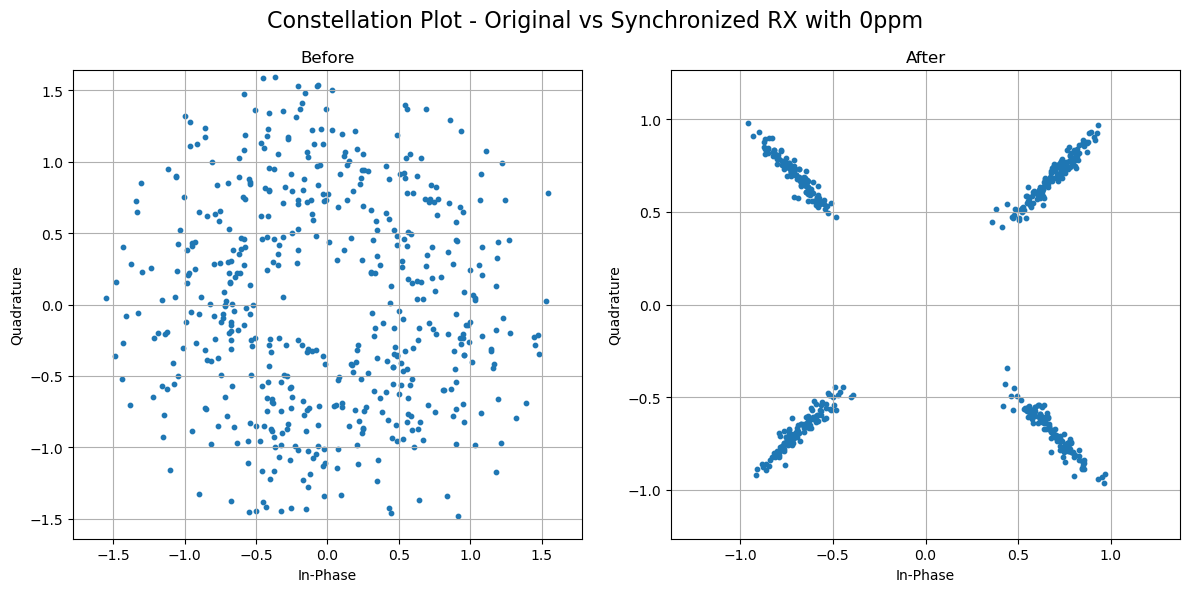

In [11]:
# Compute EVM and SER
evm_rms, evm_db, ser = compute_metrics(corrected[mask], tx_syms[mask])
print(f"RMS EVM: {evm_rms:.4f}, EVM (dB): {evm_db:.4f}")
print(f"Symbol Error Rate (SER): {ser:.4f}")

# Plot constellation original and after synchronization
plot_constellations(rx_syms_orig, corrected, symbol_index=symbol_index, zero_idx=zero_idx, axis_lim=1.5,
                    title1="Before", title2="After", fig_title="Constellation Plot - Original vs Synchronized RX with 0ppm")


### End-to-End Synchronization
In the final stage, all individual synchronization components were combined into a unified function, implementing a complete end-to-end synchronization pipeline for the receiver.

In [12]:
def phase_synchronizer(rx_frame, tx_signal, calibration_signal=None,
                       subcarrier_range=259, num_subcarriers=1024, pilot_interval=7,
                       pll_zeta=0.707, pll_BnTs=0.1, plot=True):
    """
    Phase synchronizer for QPSK symbols.

    Parameters:
        rx_frame : np.ndarray
            Received time-domain frame (complex or real)
        tx_signal : np.ndarray
            Transmitted time-domain signal (complex or real)
        calibration_signal : np.ndarray
            Calibration RX frame (optional)
        subcarrier_range : int
            Half-width of used subcarriers (default: 259 for [-259:+259])
        num_subcarriers : int
            Total FFT size (default: 1024)
        n_pilot : int
            Number of pilot symbols (default: 7)
        pll_zeta : float
            Damping factor for PLL (default: 0.707)
        pll_BnTs : float
            Phase noise bandwidth for PLL (default: 0.1)

    Returns:
        corrected : np.ndarray
            Phase-corrected symbols
        rx_syms_orig : np.ndarray
            Original RX symbols (before calibration)
    """

    assert pilot_interval % 7 == 0, "Pilot interval must be a multiple of 7"

    # Compute FFTs and extract symbols
    _, rx_syms_orig, _, _ = process_rx_tx_fft(rx_frame, tx_signal)

    # Align RX with TX in time domain
    rx_frame_aligned, _, _ = align_rx_with_tx(rx_frame, tx_signal, plot=plot)

    # Calibrated RX frame and symbols
    tx_syms, rx_syms, tx_fft, rx_fft = process_rx_tx_fft(rx_frame_aligned, tx_signal, calibration_signal)

    # Index axis
    symbol_index = np.arange(0, len(tx_syms))
    zero_idx = len(tx_syms) // 2 + 1 # 0 Hz index for TX and RX symbols
    mask = symbol_index != zero_idx # mask 0 Hz for plotting

    # Pilot based phase error estimation
    tx_syms = tx_syms / np.sqrt(tx_syms * np.conj(tx_syms)) # normalize TX symbols
    sym_err = rx_syms * np.conj(tx_syms) / (tx_syms * np.conj(tx_syms)) # calculate error based on LSE
    phase_diff = np.angle(sym_err) # phase difference
    phase_unwrapped_1 = np.unwrap(phase_diff) # unwrap phase difference

    pilot_interval = pilot_interval # pilots are distributed in every "pilot_interval"
    idx_pilot = symbol_index[::pilot_interval] # pilot indexes
    phase_pilot = phase_unwrapped_1[::pilot_interval]

    # interpolate the phase difference
    f = interp1d(idx_pilot, phase_pilot, kind='cubic')
    phase_interp = f(symbol_index)

    # Phase Equalization
    rx_syms_equalized = np.array([sym*np.exp(-1j * phase_interp[i]) for i, sym in enumerate(rx_syms)])
    # Remaining phase error
    sym_err = rx_syms_equalized * np.conj(tx_syms) / (tx_syms * np.conj(tx_syms)) # calculate error based on LSE
    phase_diff = np.angle(sym_err) # phase difference
    phase_unwrapped_2 = np.unwrap(phase_diff) # unwrap phase difference

    corrected, phase_track = pll_qpsk(rx_syms_equalized, phase_init=phase_unwrapped_2, zeta=pll_zeta, BnTs=pll_BnTs,
                                      pilot_interval=pilot_interval, tx_syms=tx_syms)
    
    if plot:
        # Plot pilot based phase estimation
        plt.figure(figsize=(14, 5))
        plt.plot(symbol_index[mask], phase_unwrapped_1[mask], label="Phase Difference", linewidth=2)
        plt.plot(symbol_index[mask], phase_interp[mask], '--r', label=f"Interpolated Phase Estimation", linewidth=2)
        plt.plot(idx_pilot, phase_pilot, 'o', label="Pilot Points", markersize=5)
        plt.xlabel("Symbol Index")
        plt.ylabel("Phase (radians)")
        plt.title("Phase Difference Between RX and TX Symbols (After Time Domain Alignment)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot phase tracking
        plt.figure(figsize=(14, 5))
        plt.plot(symbol_index[mask], phase_track[mask], label="PLL Phase Estimate", linewidth=2.0)
        plt.plot(symbol_index[mask], phase_unwrapped_1[mask]-phase_interp[mask], linestyle='--', label="Remaining Phase Difference", linewidth=1.5)
        plt.title("PLL - Tracked Phase Estimate")
        plt.xlabel("Symbol Index")
        plt.ylabel("Phase (radians)")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return corrected, rx_syms_orig

## Experiment 2
Now, we tested the same synchronization pipeline on a received frame with deliberately introduced 20 ppm of carrier frequency offset.

TX shape: (1, 2, 1024), RX shape: (256, 2, 1024), Calib RX shape: (32, 2, 1024)


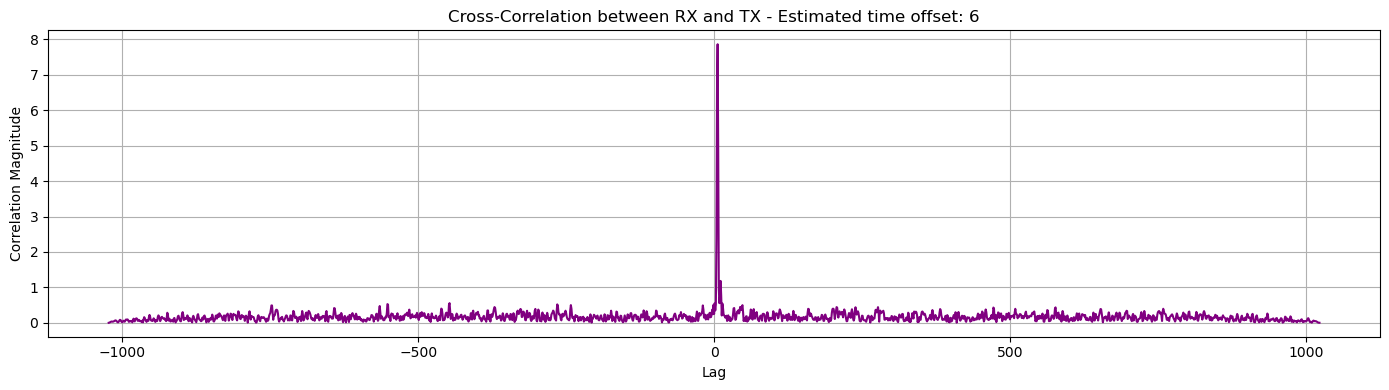

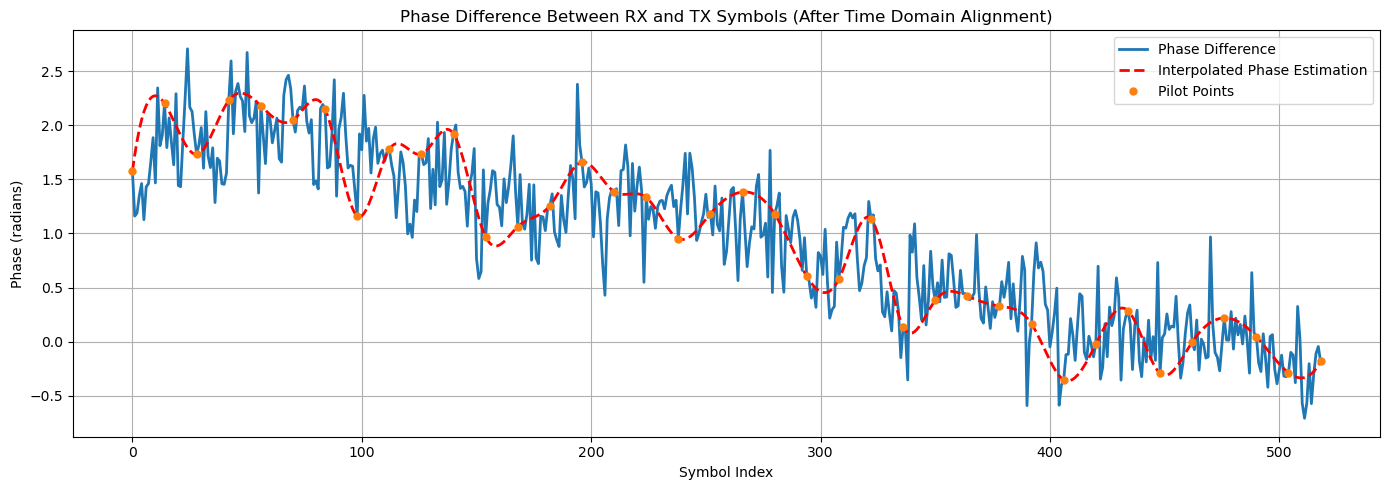

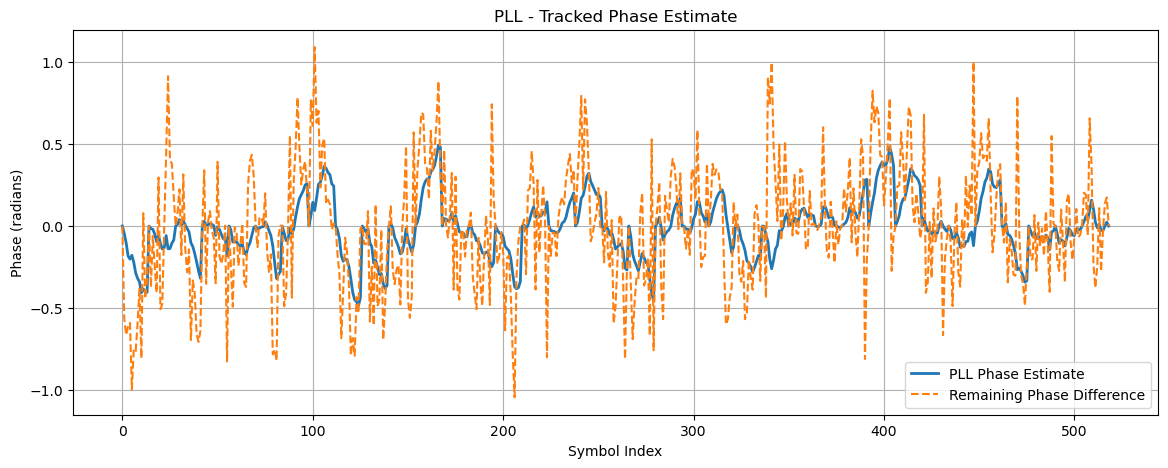

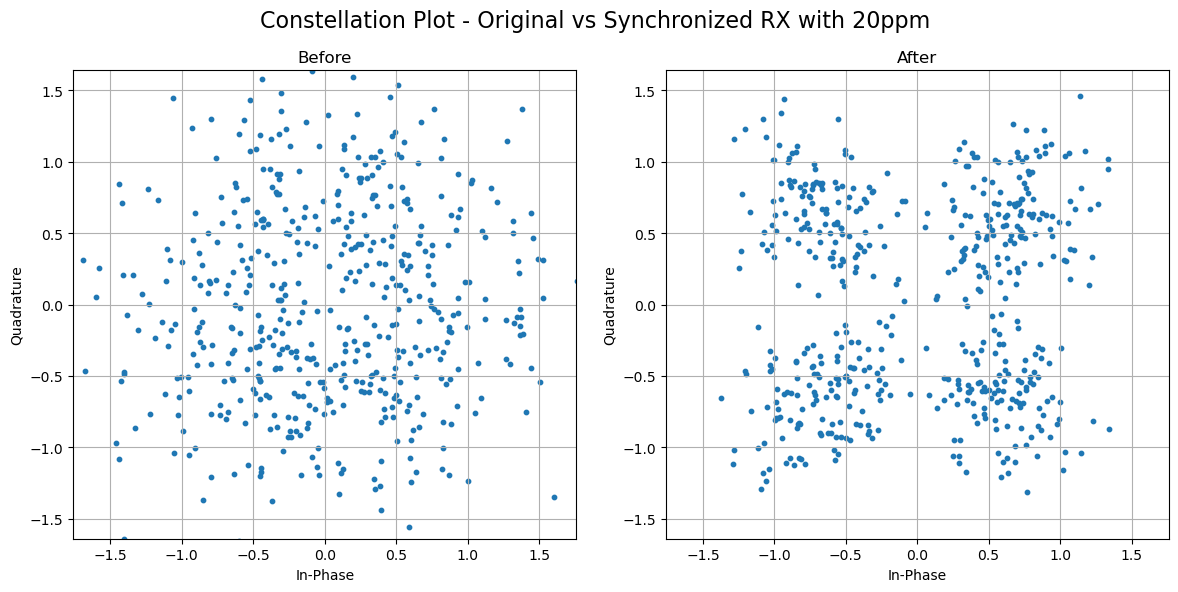

RMS EVM: 0.4054, EVM (dB): -7.8425
Symbol Error Rate (SER): 0.0232


In [13]:
# Load data and choose RX frame and antenna
data_path = '10.0GHz_20ppm.npz'
calibration_data_path = '0_tx1_rx1_rx_rotate.npz'
rx_frame, tx_signal, calibration_signal = load_data(data_path, calibration_data_path, rx_frame=0, antenna=0)

# Synchronization
corrected, rx_syms = phase_synchronizer(
        rx_frame, tx_signal, calibration_signal=calibration_signal,
        subcarrier_range=259, num_subcarriers=1024, pilot_interval=14,
        pll_zeta=0.707, pll_BnTs=0.05
    )

# Plot the equalized constellation
plot_constellations(rx_syms, corrected, symbol_index=symbol_index, zero_idx=zero_idx, axis_lim=1.5,
                    title1="Before", title2="After", fig_title="Constellation Plot - Original vs Synchronized RX with 20ppm")

# Compute EVM and SER
evm_rms, evm_db, ser = compute_metrics(corrected[mask], tx_syms[mask])
print(f"RMS EVM: {evm_rms:.4f}, EVM (dB): {evm_db:.4f}")
print(f"Symbol Error Rate (SER): {ser:.4f}")


### Conclusion

In summary, even the received frame without any deliberately introduced CFO exhibits noticeable time-varying phase offset. Nevertheless, our synchronization pipeline effectively mitigates this impairment, achieving near-perfect alignment of the received signal with *0% Symbol Error Rate (SER)* and an *EVM of -15.8 dB*.

To evaluate robustness, we tested a more challenging scenario by introducing a deliberate 20 ppm CFO. Although perfect synchronization becomes more difficult under this condition, our pipeline still performs remarkably well — achieving *2.3% SER* and *-7.8 dB EVM*.

These results highlight the *effectiveness and resilience* of our custom synchronization pipeline under both ideal and impaired channel conditions.

### Acknowledgment
I would like to thank Prof. Sundeep and his student Ali for their support in collecting data using the Pi Radio and assisting with the experimental setup in the lab.
